# Generatore della popolazione

Questo modulo contiene tutte le funzioni necessarie all'algoritmo genetico. Non prevedo un oggetto "problema" con cui agganciare tutti i metodi o gli attributi ma sono
distribuiti nel file.

## Funzione fitness

Definisco la fitness come il costo associato alla soluzione albero nel seguente modo:

$\sum_{(i,j) \in A} c_{ij}x_{ij} + \delta(c_{max}(R(\mathbf{x}) - R_0)^2)$

$ \delta =  \begin{cases}
      0 & R(\mathbf{x}) < R_0 \\
      1 & R(\mathbf{x}) \ge R_0
   \end{cases} $

$ c_{max} = max(c_{ij}) \qquad R_0 $ è il target di capacità massima che voglio per ogni arco

Sia dato un grafo $ G = (N, A) $ e un albero di copertura $T \subset A $. Definiamo la funzione $R(\mathbf{x}) : A \rightarrow \Re $ con $ \mathbf{x} \in T$
vettore di archi, come la funzione di conteggio dei nodi che vengono serviti da un certo arco $ x_{ij} $, gli archi appartengono tutti all'albero $T$ sotto esame.
Questa funzione mi dice qual è il numero totale di nodi che un certo arco sta servendo.

Questa formulazione può essere vista come una formulazione rilassata di quella originale. In particolare ho rilassato con la variabile indicatore il vincolo del
rispetto della capacità. Come descritto sopra ho usato una funzione di accumulazione  $ R(\mathbf{x}) $ e non più la formulazione classica basata su archi.

Poiché nella formulazione originale i vincoli accoppianti erano proprio quelli di capacità e sono sempre questi che rendono il problema NP-hard, è naturale lavorare
principalmente su questo vincoli e poi pensare all'interezza delle variabili (si veda la formulazione nel file [principale](main_pipeline.ipynb)).

Se considerassi $\delta$ come una sorta di moltiplicatore di Lagrange frutto del rilassamento (col quale penalizzo il non rispetto del vincolo $ R(\mathbf{x}) < R_0 $)
allora ha senso inserire il termine $\delta(c_{max}(R(\mathbf{x}) - R_0)^2)$ come penalità nella funzione fitness.

## Funzione di conteggio $R(\mathbf{x})$

Per il conteggio si usa la seguente funzione `measure_branch`, si riporta di seguitio il codice per comodità:

In [14]:
import inspect
from random import random, randint

import networkx as nx
import numpy as np

from CMST_package.individual import Individual
from CMST_package.population_generator import measure_branch, draw_graph, self_mutation

NUM_NODES = 7
CAPACITY = 4
MAXIMUM_FITNESS = 1000
POP_SIZE = 10
TOURNAMENT_SIZE = 2
breeding_mutation_pb = 0.3

lines = inspect.getsource(measure_branch)
print(lines)

def measure_branch(tree, parent, prev):
    """
    Questa funzione conta in modo ricorsivo quanti nodi ci sono in un certo sottoalbero/brach e mi accumula il tutto.

    :param tree:
    :param parent:
    :param prev:
    :return:
    """
    weight = 0
    for edge in tree:
        if edge[0] == parent and edge[1] != prev:
            weight += measure_branch(tree, edge[1], parent)
        elif edge[0] != prev and edge[1] == parent:
            weight += measure_branch(tree, edge[0], parent)
    return weight + 1



La funzione sopra riportata esegue in modo ricorsivo una ricerca simile allo stile breadth-first in modo ricorsivo.
Per ulteriori dettagli si veda la documentazione.

    1. Creo un individuo di test:

In [15]:
matrix = np.zeros((NUM_NODES, NUM_NODES))
ind = Individual(size=int(NUM_NODES * (NUM_NODES + 1) / 2), min=1, iter_range=100)

    2. Rieseguo la procedura per ritornare dal genoma (aleatorio) del mio [individuo](individual.ipynb) test alla matrice di adiacenza (con cui posso lavorare)

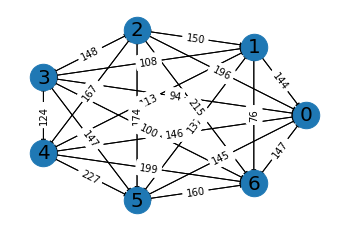

<Figure size 864x864 with 0 Axes>

In [16]:
matrix = np.array(ind.reshape2matrix(NUM_NODES))
n = matrix.shape[0]
matrix[range(n), range(n)] = "0"
shape = matrix.shape
result = np.zeros(shape, dtype=int)
for x in range(0, shape[0]):
    for y in range(0, shape[1]):
        result[x, y] = str(matrix[x, y])[0:2]
g = nx.from_numpy_matrix(matrix, create_using=nx.DiGraph)
draw_graph(g, 0)

    3. Ottengo un MST classico con l'algoritmo di Prim

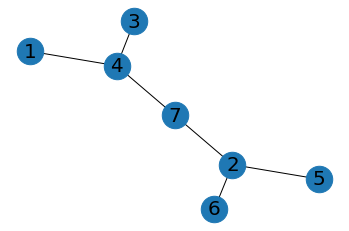

<Figure size 864x864 with 0 Axes>

In [17]:
from CMST_package.population_generator import prim

tree = prim(matrix)
G = nx.Graph()
tree = [arc for arc in tree if arc != (0, 0)]
G.add_edges_from(tree)
draw_graph(G, 1)

    4. Conto i nodi che ci sono in ogni ramo con una procedura breadth-first search, realizzando un primo prototipo della funzione $R(\mathbf{x})$

In [18]:
# Depth first search starting from ROOT
over_capacity = False
ROOT = 1
tree_final = []
for edge in tree:
    temp_weight = 0
    if edge[0] == ROOT:
        temp_weight = measure_branch(tree, edge[1], ROOT)
        print("Dal nodo radice {0} ho {1} nodi".format(ROOT, temp_weight))
    elif edge[1] == ROOT:
        temp_weight = measure_branch(tree, edge[0], ROOT)
        print("Nodi incidenti nella radice----> {0}".format(temp_weight))
    if temp_weight > CAPACITY:
        tree_final = tree
        ind.fitness = MAXIMUM_FITNESS
        over_capacity = True
        print(
            "Violato il vincolo di capacità!! Ho {0} nodi nell'arco {1} arco invece che {2} ".format(temp_weight, edge,
                                                                                                     CAPACITY))
        break

Dal nodo radice 1 ho 6 nodi
Violato il vincolo di capacità!! Ho 6 nodi nell'arco (1, 4) arco invece che 4 


### Osservazioni

Poiché questi genomi sono (per facilitare di test) aleatori, è probabile che si possano incontrare casi in cui un arco sia sovraccarico.
Quando questo accade scatta la guardia situata nell'ultimo `if` e cioè:

```python
if temp_weight > CAPACITY:
    tree_final = tree
    ind.fitness = MAXIMUM_FITNESS
    over_capacity = True
    print("Violato il vincolo di capacità!! Ho {0} nodi nell'arco {1} arco invece che {2} ".format(temp_weight, edge, CAPACITY))
    break
```

## Calcolo della fitness

__Se__ il numero di nodi rispetta il vincolo di capacità si passa al calcolo del costo effettivo sulla _matrice_ _originale_ $\sum_{(i,j) \in A} c_{ij}x_{ij} $

In [19]:
if not over_capacity:
    weight = 0
    for edge in tree:
        (col, row) = edge
        weight += matrix[col - 1][row - 1]
    ind.tree = tree
    ind.fitness = weight
    print("Costo dell'albero soluzione: {0}".format(weight))
else:
    print("Non ho trovato soluzioni, riprova a lanciare l'algoritmo...")

Non ho trovato soluzioni, riprova a lanciare l'algoritmo...


### Osservazioni
Anche qui bisogna precisare che mi sono allontanato leggermente dalla formulazione originale. Il costo $\sum_{(i,j) \in A} c_{ij}x_{ij} $ è calcolato sulla matrice
originale, cioè quella data in input da ottimizzare, ma se l'individuo sotto esame ha un albero che non rispetta i vincoli di capacità allora gli
viene assegnata una fitness massima (nel codice è uguale a `MAXIMUM_FITNESS`) e viene calcolato il costo comunque. Questo costo, che viene tradotto in
fitness dalle funzioni `fitness_evaluation` e `measure_branch` sarà sopra al valore `MAXIMUM_FITNESS`, rendendo questo individuo inutile.
* Per quale motivo tenere delle soluzioni che violano il vincolo di capacità?
Poiché può succedere che nonostante tutte le iterazioni non riesco a generare un numero sufficiente di soluzioni ammissibili (per vederlo basta allargare la dimensione
Hall of Fame e diminuire le iterazioni e si osservano soluzioni assurde addirittura con cicli...)
* Come mi accorgo di avere una soluzione finale che viola questi vincoli?
Basta osservare la sua fitness, se è pari a `MAXIMUM_FITNESS` allora la soluzione è inammissibile, oppure anche se non del tutto inammissibile (cioé mi accontento
di qualcosa di papabile) questa soluzione sarà pessima. (Invito a provare con varie dimensioni di Hall of Fame e iterazioni nel loop evolutivo).

## Operatore di crossover

La mutazione a coppia implementata qui è un crossover uniforme. Per mostrare come opera questa funzione:

> 1. Creazione di una popolazione iniziale (per l'implementazione del generatore di popolazioni si veda la documentazione)

In [20]:
from CMST_package.population_generator import generate_population

individuals = generate_population(POP_SIZE + (POP_SIZE % 2), int(NUM_NODES * (NUM_NODES + 1) / 2))

> 2. Selezione del gruppo che si accoppierà

In [21]:
group_A = list()
group_B = list()

# Selezione di chi si accoppia Tournament style
mating_group = list()
while len(mating_group) < len(individuals):
    best = None
    for i in range(TOURNAMENT_SIZE):
        # Scegli un individuo a caso
        ind = individuals[randint(0, len(individuals) - 1)]
        # Se l'individuo scelto a caso ha una fitness maggiore -> prendilo
        if best is None or ind.fitness > best.fitness:
            best = ind
    mating_group.append(best)
print("Visualizzazione di un individuo a caso: {0}".format(mating_group[1]))

Visualizzazione di un individuo a caso: 150 222 213 33 206 204 32 214 121 100 202 256 25 40 97 236 69 130 77 130 201 63 243 4 211 230 105 85 


> 3. Estrazione a coppie dei genitori e ripopolazione della "lista padri" e della "lista madri"

In [22]:
while mating_group:
    group_A.append(mating_group.pop())
    group_B.append(mating_group.pop())

> 4. Crossover

In [23]:
ret = list()
for i in range(len(group_A)):
    ind1 = group_A.pop()
    ind2 = group_B.pop()
    if random() < breeding_mutation_pb:
        for i in range(randint(1, len(ind1))):
            # Qui avviene lo scambio
            temp = ind1[i]
            ind1[i] = ind2[i]
            ind2[i] = temp
    ret.append(ind1)
    ret.append(ind2)


## Single Mutation

In modo simile a come fatto per la mutazione a coppia si procede qui nella mutazione del singolo individuo. In pratica seleziono un gene (che qui
sono i costi della lista di adiacenza) e li modifico in modo casuale in modo da cambiare il costo del singolo arco.

In [24]:
lines = inspect.getsource(self_mutation)
print(lines)

def self_mutation(individuals, mutation_pb):
    """
    Self-mutation qui con questa funzione modifico il genotipo del singolo individuo, in pratica è come se gli
    modificassi la matrice equivalente dei costi in modo casuale.
    Potrei modificare un ramo, ma se così facessi otterrei una euristica di scambio (branch exchange heuristic).
    Non seguo questa seconda strada (altrimenti otterrei qualcosa come Esau-Williams) modifico la matrice di adiacenza.

    :param individuals: popolazione da mutare (in pratica un insieme di individui)
    :param mutation_pb: probabilità di mutazione di un gene
    :return:
    """
    for individual in individuals:
        for value in individual:
            if random.random() < mutation_pb:
                value = random.randrange(0, INDEX_RANGE)
    return individuals



Per dettagli e scelte implementative si veda la documentazione delle funzion, oppure il `help()` delle funzioni.